In [11]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/IPS.jl")
include("../Inversion/Plot.jl")
include("../Inversion/RWMCMC.jl")
include("../Inversion/SMC.jl")
include("../Inversion/KalmanInversion.jl")

solve_β (generic function with 2 methods)

In [12]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

Setup_Param

## Gaussian Mixture Kalman Inversion

## Double banana likelihood function

We will explore the question with the following inverse problem 

$$
\begin{align*}
y = 
\log
\Bigl(
(1 - \theta_{(1)})^2 + 100(\theta_{(2)} - \theta_{(1)}^2)^2
\Bigr)
+\eta
\qquad 
\theta_{ref} = 
\begin{bmatrix}
0\\
0
\end{bmatrix} 
\qquad
\Sigma_{\eta} = 
\begin{bmatrix}
0.3^2 
\end{bmatrix} 
\end{align*}
$$

which leads to the 2-dimensional Rosenbrock likelihood function
    
$$\exp\Big(-\frac{\left(y_1 - (\theta_{(2)} - \theta_{(1)}^2)\right)^2}{2\sigma_{\eta_1}^2} - \frac{\left(y_2 - \theta_{(1)}\right)^2}{2\sigma_{\eta_2}^2}\Big)$$

We focus on the Gaussian prior $\mathcal{N}(0, 1^2 I)$.
     

In [13]:
function func_G(θ)
    θ₁, θ₂ = θ
    return [(θ₂ - θ₁)^2;]
end

function log_prior(θ, μ0, σ0)
    θ₁, θ₂ = θ
    return -((θ₁ - μ0[1])^2 + (θ₂ - μ0[2])^2)/(2σ0^2)
end

function log_double_banana(θ, μ0, σ0, y, ση)
    θ₁, θ₂ = θ
    return -(y[1] - func_G(θ)[1])^2/(2ση^2) + log_prior(θ, μ0, σ0)
end

function forward(s_param::Setup_Param, θ)
    return func_G(θ)
end


forward_aug = (s_param, θ) -> vcat(forward(s_param, θ), θ)



#121 (generic function with 1 method)

In [14]:
using ForwardDiff
using KernelDensity
function double_banana(μ0 = [0.0;0.0]; Run_MCMC = false, Run_Fisher_Rao = false)

    σ0 = 1.0
    Σ0 = [σ0^2 0.0;0.0  σ0^2]

    ση = 1.0
    Σ_η = [ση^2;;]
    y = [4.2297;]

    @info "y = ", y

    # compute posterior distribution by MCMC
    
    if Run_MCMC
        step_length = 0.1
        n_ite = 10^7
        us = RWMCMC_Run(θ->log_double_banana(θ, μ0, σ0, y, ση), μ0, step_length, n_ite);
        everymarker = 100
        fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
        n_burn_in, n_end = div(n_ite, 10), n_ite
        ax.scatter(us[n_burn_in:everymarker:n_end, 1], us[n_burn_in:everymarker:n_end, 2], s = 0.1, label="MCMC")
        ax.legend()
    end
    
    
    

    N_y, N_θ = 1, 2
    # compute posterior distribution by GMKI
    update_freq = 1
    N_iter = 30
    N_modes = 3
    θ0_w  = ones(N_modes)/N_modes
    θ0_mean, θθ0_cov  = zeros(N_modes, N_θ), zeros(N_modes, N_θ, N_θ)


    Random.seed!(2);
    for m = 1:N_modes
        θ0_mean[m, :]    .= rand(MvNormal(zeros(N_θ), Σ0)) + μ0
        θθ0_cov[m, :, :] .= Σ0
    end


    s_param_aug = Setup_Param(N_θ, N_y+N_θ)
    y_aug = [y ; μ0]

    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]
    
    
    Δt = 0.5
    gmkiobj = GMKI_Run(s_param_aug, forward_aug, θ0_w, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, Δt, update_freq, N_iter; unscented_transform="modified-2n+1")
    
    

    
    
    
    if Run_Fisher_Rao
        s_param = Setup_Param(N_θ, N_y)
        N_ens  = 1000
        method  = "Wasserstein-Fisher-Rao"
        preconditioner = false             # true
        Δt, N_t = 1e-2, 10^3
        
        logρ = θ ->log_double_banana(θ, μ0, σ0, y, ση)
        
        function compute_∇logρ(s_param, θ)
            return logρ(θ), ForwardDiff.gradient(logρ, θ)
        end   
        θ0 = Array(rand(MvNormal(μ0, Σ0), N_ens)')   
        kernel_param = nothing
        ipsobj = IPS_Run(s_param, compute_∇logρ, θ0, N_ens, Δt, N_t, method, preconditioner, kernel_param)
        
        
        fig, ax = PyPlot.subplots(ncols=1, sharex=false, sharey=true, figsize=(6,4))
        n_burn_in, n_end = div(N_t, 10)*N_ens, N_t*N_ens
        θs = vcat(ipsobj.θ...)[n_burn_in:n_end, :]
        ax.scatter(θs[:, 1], θs[:, 2], s = 0.1, label=method)
        ax.legend()
    end
    
    

    # visualization 
    x_min, x_max = -4.0, 4.0
    y_min, y_max = -4.0, 4.0
    Nx, Ny = 2000, 2000
    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)' 
    
    Z_ref = copy(X)
    for i = 1:Nx
        for j = 1:Ny
            temp = [X[i,j] ; Y[i,j]]
            Z_ref[i,j] = exp(log_double_banana(temp, μ0, σ0, y, ση))
        end
    end
    Z_ref /= ( sum(Z_ref)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
    
    
    
    
    plot_every = 10
    # Visualize different iterations
    for iter  = [1:plot_every:N_iter; N_iter]
        nrows, ncols = 1, 3
        fig, ax = PyPlot.subplots(nrows=nrows, ncols=ncols, sharex=false, sharey=false, figsize=(15,5))
        # plot GMKI results 

        
        
        color_lim = (minimum(Z_ref), maximum(Z_ref))
        ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)
        ax[1].set_xlabel(L"\theta_{(1)}")
        ax[1].set_ylabel(L"\theta_{(2)}")
        ax[1].set_title("Reference")
        
        if Run_MCMC
            kernel = kde(us[n_burn_in:n_end, :])
            Z = pdf(kernel, xx, yy)
            ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[3].set_xlabel(L"\theta_{(1)}")
            ax[3].set_ylabel(L"\theta_{(2)}")
            ax[3].set_title("MCMC")
            
            @info "MCMC L₁ error = ", sum(abs.(Z - Z_ref))/sum(abs.(Z_ref))
        end
        
        
        if Run_Fisher_Rao
            
            θs = ipsobj.θ[end]
            
            kernel = kde(θs)
            Z = pdf(kernel, xx, yy)
            Z /= (sum(Z)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
            ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
            ax[3].scatter([θs[:,1];], [θs[:,2];], marker="o", color="b", s=2, alpha=0.2)
        
            ax[3].set_xlabel(L"\theta_{(1)}")
            ax[3].set_ylabel(L"\theta_{(2)}")
            ax[3].set_title("BDLS-KL")
            
            @info "Fisher-Rao L₁ error = ", sum(abs.(Z - Z_ref))/sum(abs.(Z_ref))
        end

        Z = zeros(N_modes, Nx, Ny)
        # plot GMKI results 
        for i =1:N_modes
            gmki_θ_mean = gmkiobj.θ_mean[iter][i, :]
            gmki_θθ_cov = gmkiobj.θθ_cov[iter][i, :, :]
            _,_, Z[i, :, :] = Gaussian_2d(gmki_θ_mean, gmki_θθ_cov, Nx, Ny, x_min, x_max, y_min, y_max) 
            Z[i,:,:] *= exp(gmkiobj.logθ_w[iter][i])

        end
        Z_GMKI = sum(Z, dims=1)[1,:,:]
        Z_GMKI /= (sum(Z_GMKI)*(xx[2]-xx[1])*(yy[2]-yy[1]) )
        ax[2].pcolormesh(X, Y, Z_GMKI, cmap="viridis", clim=color_lim)
        @info "GMKI L₁ error = ", sum(abs.(Z_GMKI - Z_ref))/sum(abs.(Z_ref))
        
        
        linestyles = ["o"; "x"; "s"]
        for i =1:N_modes
            gmki_θ_mean = gmkiobj.θ_mean[iter][i, :]
            gmki_θθ_cov = gmkiobj.θθ_cov[iter][i, :, :]
            ax[2].scatter([gmki_θ_mean[1];], [gmki_θ_mean[2];], marker=linestyles[i], color="C"*string(i), facecolors=(linestyles[i]=="x" ? nothing : "none"), linewidths=3)
            ax[2].scatter([gmkiobj.θ_mean[1][i, :][1];], [gmkiobj.θ_mean[1][i, :][2];], marker=linestyles[i], color="black", facecolors=(linestyles[i]=="x" ? nothing : "none"), linewidths=3)
        end
        
        ax[2].set_xlabel(L"\theta_{(1)}")
        ax[2].set_ylabel(L"\theta_{(2)}")
        ax[2].set_title("GMKI")
        
        if !Run_Fisher_Rao & !Run_MCMC
            markevery = 5
            θ_w = exp.(hcat(gmkiobj.logθ_w...))
            for i =1:N_modes
                ax[3].plot(Array(0:N_iter-1), θ_w[i, 1:N_iter], marker=linestyles[i], color = "C"*string(i), fillstyle="none", markevery=markevery, label= "mode "*string(i))
            end
            ax[3].set_xlabel("Iterations")
            ax[3].set_ylabel("Weights")
            ax[3].legend()
        end
        
        fig.tight_layout()
        fig.savefig("2D-density-"*string(μ0[1])*"-"*string(iter)*".png")


    end
    
    
    
end





double_banana (generic function with 2 methods)

[ Info: ("y = ", [4.2297])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Fisher-Rao L₁ error = ", 0.5511112004617803)
[ Info: ("GMKI L₁ error = ", 1.4171239626180892)
[ Info: ("Fisher-Rao L₁ error = ", 0.5511112004617803)
[ Info: ("GMKI L₁ error = ", 0.19268682799427028)
[ Info: ("Fisher-Rao L₁ error = ", 0.5511112004617803)
[ Info: ("GMKI L₁ error = ", 0.1391363894472302)
[ Info: ("Fisher-Rao L₁ error = ", 0.5511112004617803)
[ Info: ("GMKI L₁ error = ", 0.12480007146678247)


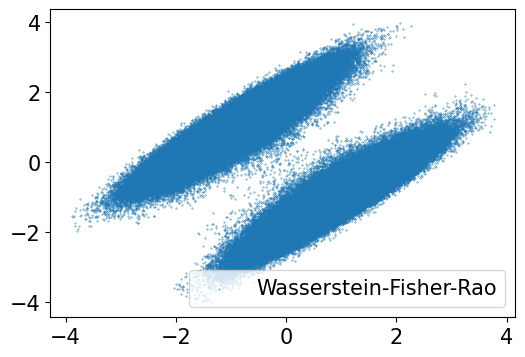

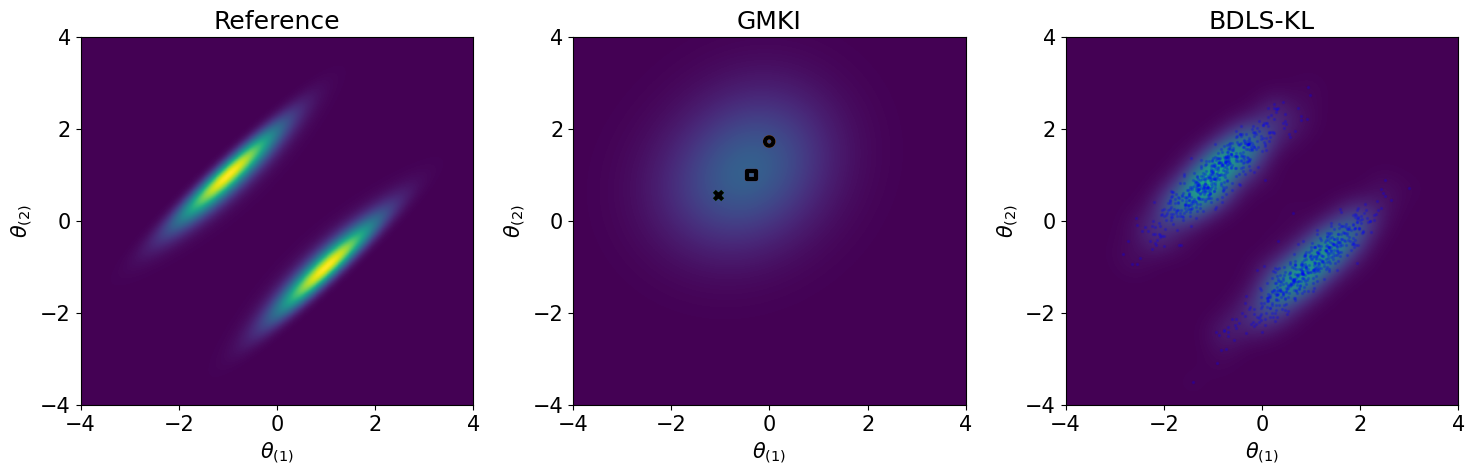

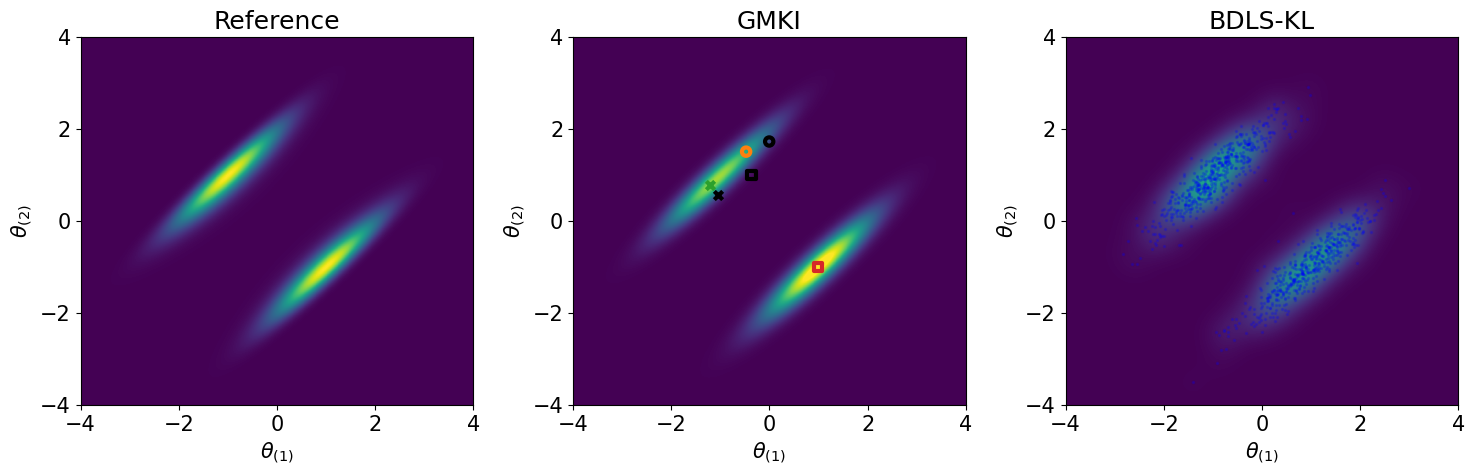

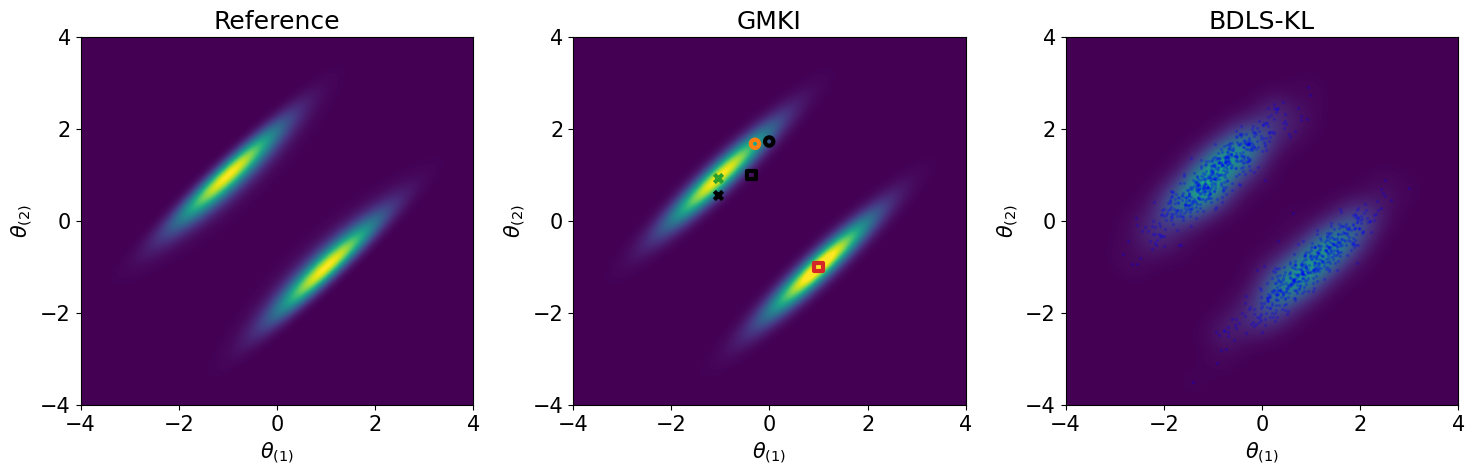

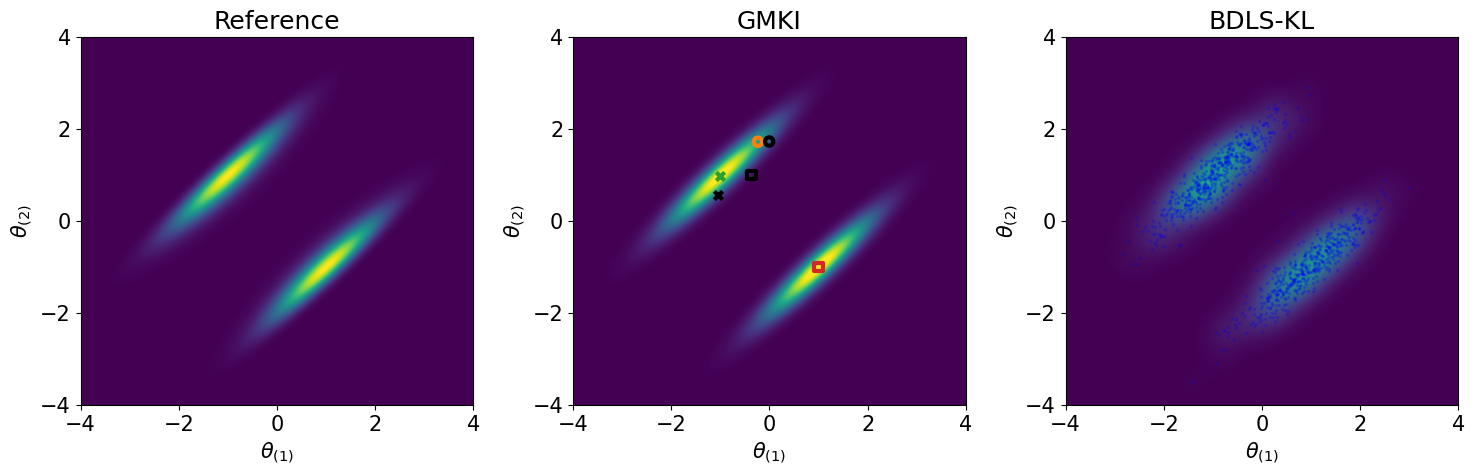

In [15]:
double_banana([0.0;0.0]; Run_MCMC=false, Run_Fisher_Rao=true)

[ Info: ("y = ", [4.2297])
[ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
[ Info: ("Fisher-Rao L₁ error = ", 0.5287443368315051)
[ Info: ("GMKI L₁ error = ", 1.507014899584478)
[ Info: ("Fisher-Rao L₁ error = ", 0.5287443368315051)
[ Info: ("GMKI L₁ error = ", 0.18715192038147685)
[ Info: ("Fisher-Rao L₁ error = ", 0.5287443368315051)
[ Info: ("GMKI L₁ error = ", 0.16422953218244052)
[ Info: ("Fisher-Rao L₁ error = ", 0.5287443368315051)
[ Info: ("GMKI L₁ error = ", 0.12670404557638057)


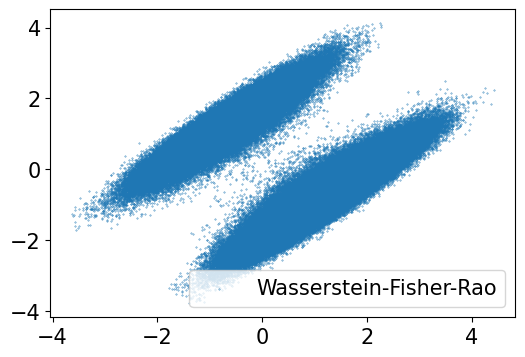

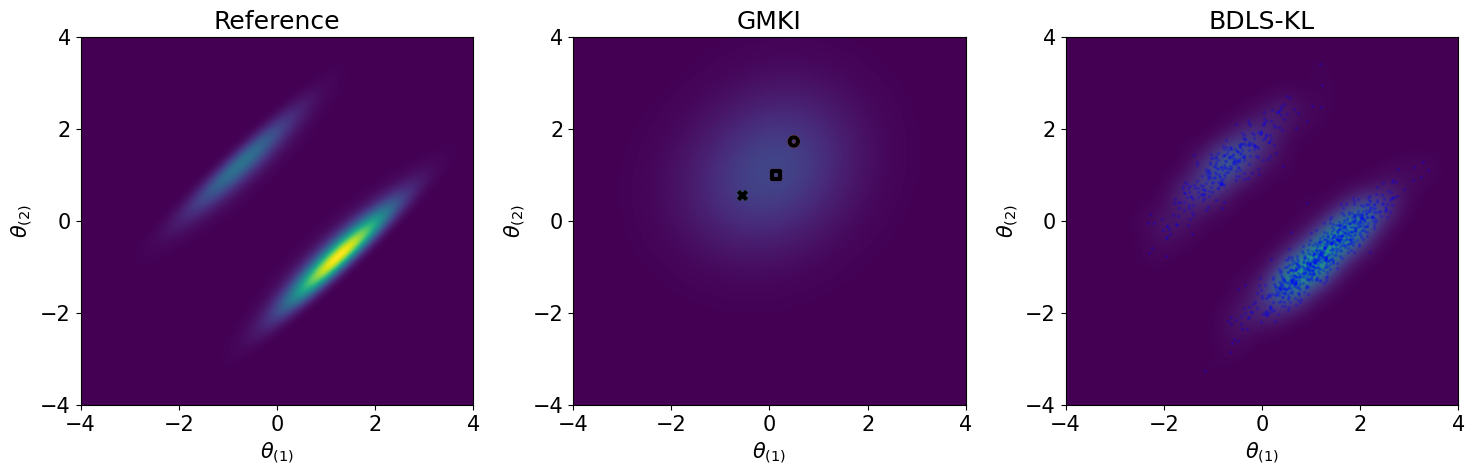

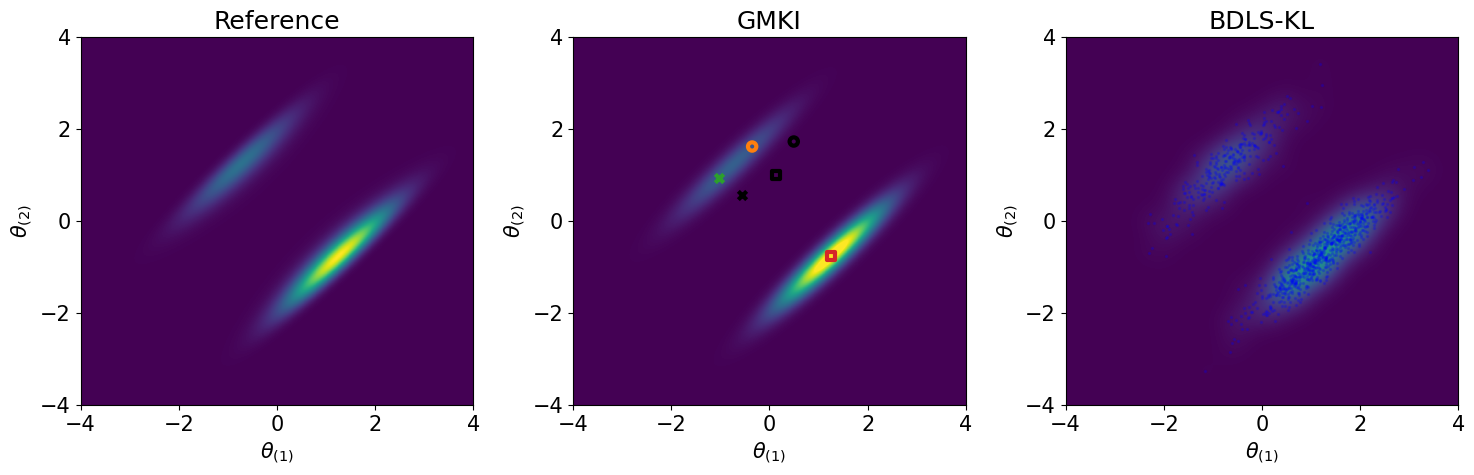

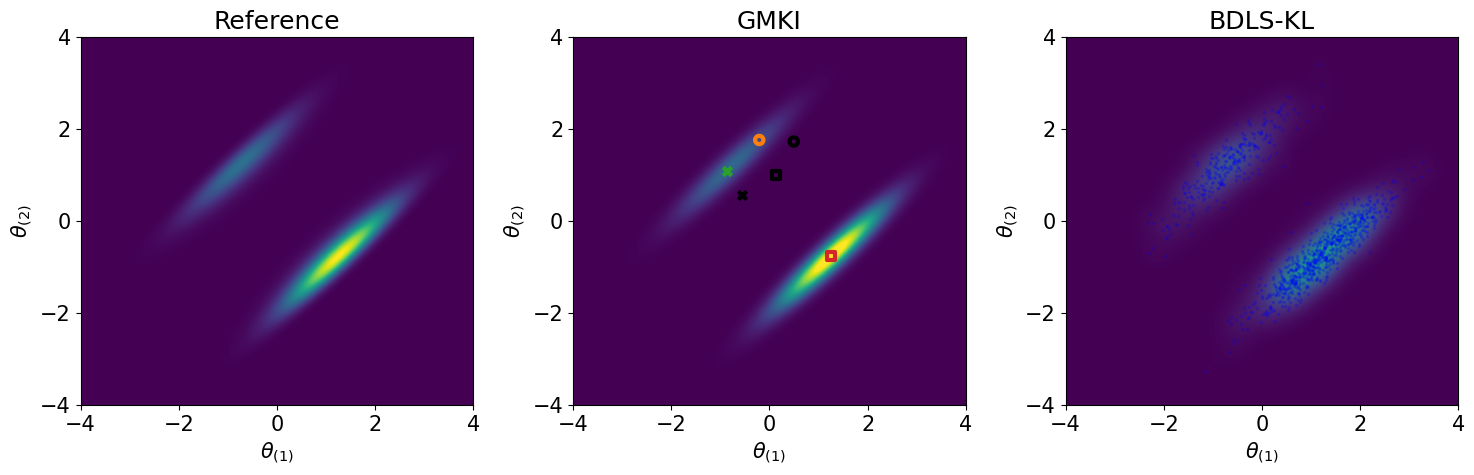

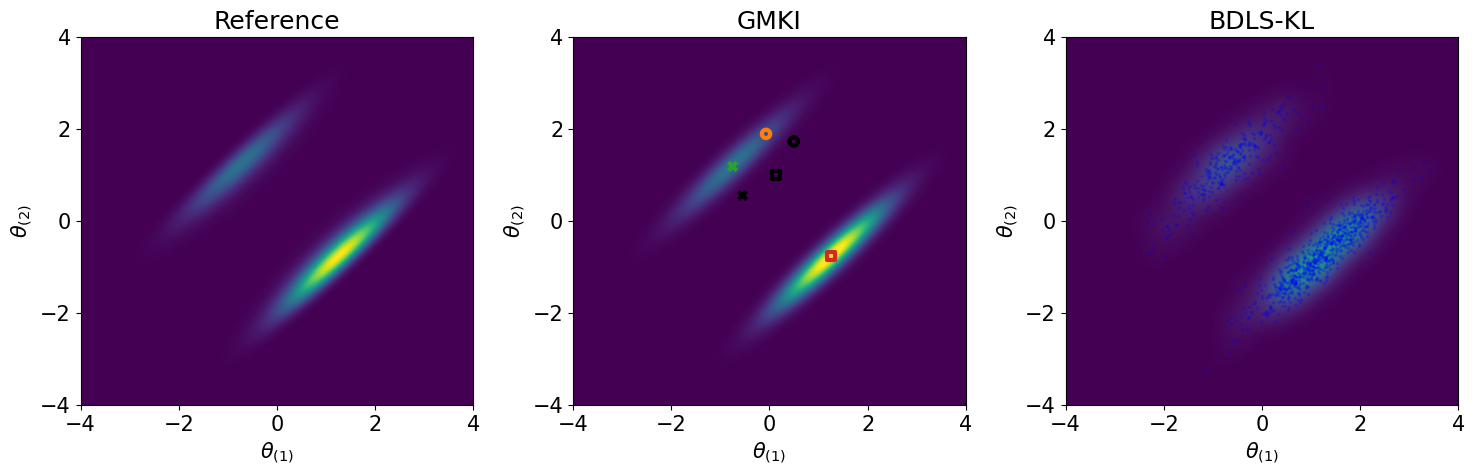

In [16]:
double_banana([0.5;0.0]; Run_MCMC=false, Run_Fisher_Rao=true)